# Статистический анализ данных сервиса аренды самокатов GoFast

В нашем распоряжении данные о некоторых пользователях из нескольких городов, а также об их поездках. Проанализируем данные и проверим некоторые гипотезы, которые могут помочь бизнесу вырасти.

Чтобы совершать поездки по городу, пользователи сервиса GoFast пользуются мобильным приложением. Сервисом можно пользоваться:
* без подписки (Free):
    * абонентская плата отсутствует;
    * стоимость одной минуты поездки — 8 рублей;
    * стоимость старта (начала поездки) — 50 рублей;
* с подпиской (Ultra):
    * абонентская плата — 199 рублей в месяц;
    * стоимость одной минуты поездки — 6 рублей;
    * стоимость старта — бесплатно.

# Введение

**Проект направлен** на анализ данных организации и проверку сформулированных гипотез для помощи бизнесу.

**Цель исследования** - проверить 3 гипотезы:

* Пользователи с подпиской тратят больше времени на поездки;
* Среднее расстояние, которое проезжают пользователи с подпиской за одну поездку, не превышает 3130 метров;
* Помесячная выручка от пользователей с подпиской по месяцам выше, чем выручка от пользователей без подписки.

**Описание исходных данных:**

Пользователи — users_go.csv:
    
 * *user_id* — уникальный идентификатор пользователя
 * *name* — имя пользователя
 * *age* — возраст
 * *city* — город
 * *subscription_type* — тип подписки (free, ultra)

Поездки — rides_go.csv:
 
 * *user_id* — уникальный идентификатор пользователя
 * *distance* — расстояние, которое пользователь проехал в текущей сессии (в метрах)
 * *duration* — продолжительность сессии (в минутах) — время с того момента, как пользователь нажал кнопку «Начать поездку» до момента, как он нажал кнопку «Завершить поездку»
 * *date* — дата совершения поездки
 
Подписки — subscriptions_go.csv:
 
 * *subscription_type* — тип подписки
 * *minute_price* — стоимость одной минуты поездки по данной подписке
 * *start_ride_price* — стоимость начала поездки
 * *subscription_fee* — стоимость ежемесячного платежа

**Исследование пройдет в 4 основных этапа:**

 * Обзор исходных данных;
 * Предобработка исходных данных;
 * Исследовательский анализ данных;
 * Проверка гипотез.

# Содержание <a id="Содержание"></a>

1. [Обзор исходных данных](#Обзор-исходных-данных)
2. [Предобработка данных](#Предобработка-данных)
    * [Изменение типа данных, добавление столбцов](#Изменение-типа)
    * [Устранение неявных дубликатов](#Устранение-неявных)
    * [Устранение явных дубликатов](#Устранение-явных)
3. [Исследовательский анализ данных](#Исследовательский-анализ)
    * [Частота встречаемости городов](#Частота-городов)
    * [Соотношение пользователей с подпиской и без подписки](#Соотношение-подписок)
    * [Возраст пользователей](#Возраст-пользователей)
    * [Расстояние, которое пользователь преодолел за одну поездку](#Расстояние-поездки)
    * [Продолжительность поездок](#Продолжительность-поездки)
4. [Объединение данных](#Объединение-данных)
    * [Соединение таблиц](#Соединение-таблиц)
    * [Сравнение расстояния и времени поездок пользователей с подпиской и без](#Сравнение)
5. [Подсчет выручки](#Подсчет-выручки)
6. [Проверка гипотез](#Проверка-гипотез)
    * [Время на поездку у пользователей с подпиской](#Время-на-поездку)
    * [Среднее расстояние поездки у пользователей с подпиской](#Среднее-расстояние-поездки)
    * [Сравнение помесячной выручки от пользователей с подпиской и без](#Сравнение-выручки)
7. [Распределения](#Распределения)
8. [Общий вывод](#Общий-вывод)

<a id='Обзор-исходных-данных'></a>
## Обзор исходных данных

In [1]:
#импортируем необходимые для проекта библиотеки
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from scipy import stats as st
from scipy.stats import binom, norm

In [2]:
#сохраним датасеты в дф
data_users = pd.read_csv('/datasets/users_go.csv')
data_rides = pd.read_csv('/datasets/rides_go.csv')
data_subs = pd.read_csv('/datasets/subscriptions_go.csv')

Сначала проверим предложенные данные:

In [3]:
#поскольку у нас 3 дф определим функцию для оптимизации
#(откажемся от цикла, чтобы была возможность текстово описать каждый отдельный результат вывода)
def data_info(data):
    '''
    Аргумент функции - название датасета.
    Функция выводит первые 5 строк датасета, информацию по нему и гистограммы по числовым столбцам.
    '''
    display(data.head())
    data.info()
    data.hist(figsize=(15, 5))
    plt.show()

,user_id,name,age,city,subscription_type
0,1,Кира,22,Тюмень,ultra
1,2,Станислав,31,Омск,ultra
2,3,Алексей,20,Москва,ultra
3,4,Константин,26,Ростов-на-Дону,ultra
4,5,Адель,28,Омск,ultra


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1565 entries, 0 to 1564
Data columns (total 5 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   user_id            1565 non-null   int64 
 1   name               1565 non-null   object
 2   age                1565 non-null   int64 
 3   city               1565 non-null   object
 4   subscription_type  1565 non-null   object
dtypes: int64(2), object(3)
memory usage: 61.3+ KB


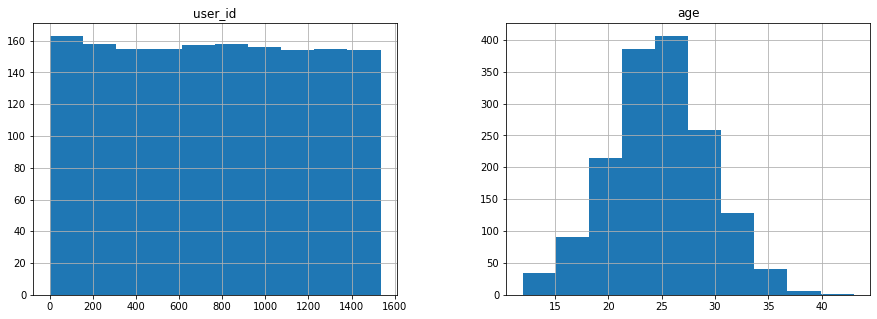

In [4]:
data_info(data_users)

В датасете с пользователями нет пропусков, типы данных в порядке, распределение значений адекватное (равномерное в id, нормальное в age).

,user_id,distance,duration,date
0,1,4409.919140,25.599769,2021-01-01
1,1,2617.592153,15.816871,2021-01-18
2,1,754.159807,6.232113,2021-04-20
3,1,2694.783254,18.511000,2021-08-11
4,1,4028.687306,26.265803,2021-08-28


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18068 entries, 0 to 18067
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   user_id   18068 non-null  int64  
 1   distance  18068 non-null  float64
 2   duration  18068 non-null  float64
 3   date      18068 non-null  object 
dtypes: float64(2), int64(1), object(1)
memory usage: 564.8+ KB


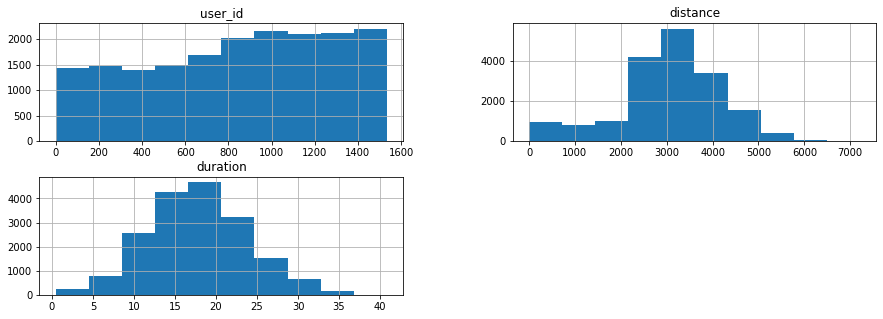

In [5]:
data_info(data_rides)

В датасете с поездками нет пропусков, значения распределены адекватно, необходимо привести данные в колонке с датами к стандартному типу.

,subscription_type,minute_price,start_ride_price,subscription_fee
0,free,8,50,0
1,ultra,6,0,199


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2 entries, 0 to 1
Data columns (total 4 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   subscription_type  2 non-null      object
 1   minute_price       2 non-null      int64 
 2   start_ride_price   2 non-null      int64 
 3   subscription_fee   2 non-null      int64 
dtypes: int64(3), object(1)
memory usage: 192.0+ bytes


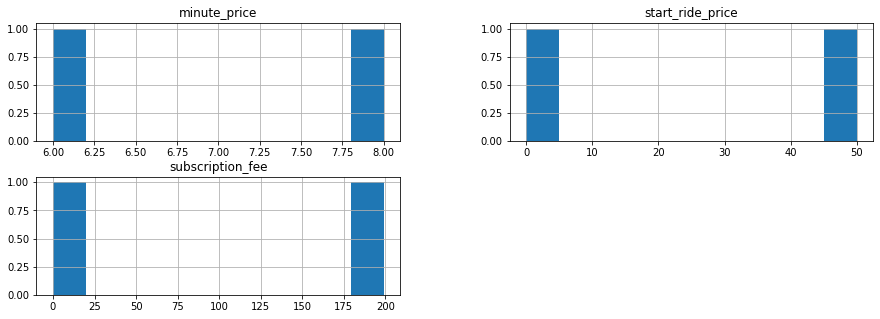

In [6]:
data_info(data_subs)

В датасете с информацией по тарифам пропусков, аномальных значений и нарушений типа данных не набдюдается.

**Вывод:**

Мы провели первичный обзор данных, не было выявлено пропусков и аномальных значений, необходимо изменить тип данных в столбце с датами в датасете с поездками.

[Вернуться к содержанию](#Содержание)

<a id="Предобработка-данных"></a>
## Предобработка данных

<a id="Изменение-типа"></a>
Для корректности изменим тип данных с object на date в аналогичном столбце датафрейма с информацией по поездкам и создадим отдельный с месяцами:

In [7]:
#меняем формат
data_rides['date'] = pd.to_datetime(data_rides['date'], format='%Y-%m-%d')
#проверим, за какой период данные у нас в наличии
data_rides['date'].describe()

/tmp/ipykernel_778/37923842.py:4: FutureWarning: Treating datetime data as categorical rather than numeric in `.describe` is deprecated and will be removed in a future version of pandas. Specify `datetime_is_numeric=True` to silence this warning and adopt the future behavior now.
  data_rides['date'].describe()


count                   18068
unique                    364
top       2021-12-22 00:00:00
freq                       72
first     2021-01-01 00:00:00
last      2021-12-30 00:00:00
Name: date, dtype: object

В нашем распоряжении данные за 1 год - 2021. Можем добавить столбец с месяцами:

In [8]:
data_rides['month'] = data_rides['date'].dt.month
#проверим изменения
data_rides.info()
data_rides.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18068 entries, 0 to 18067
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype         
---  ------    --------------  -----         
 0   user_id   18068 non-null  int64         
 1   distance  18068 non-null  float64       
 2   duration  18068 non-null  float64       
 3   date      18068 non-null  datetime64[ns]
 4   month     18068 non-null  int64         
dtypes: datetime64[ns](1), float64(2), int64(2)
memory usage: 705.9 KB


,user_id,distance,duration,date,month
0,1,4409.919140,25.599769,2021-01-01,1
1,1,2617.592153,15.816871,2021-01-18,1
2,1,754.159807,6.232113,2021-04-20,4
3,1,2694.783254,18.511000,2021-08-11,8
4,1,4028.687306,26.265803,2021-08-28,8


<a id="Устранение-неявных"></a>
Ранее мы выявили, что в наших данных нет пропусков, теперь проверим на дубликаты:

Исходя из природы данных, неявные дубликаты могут быть только в категориальных значениях типа object, сначала сфокусируемся на них.

Датафрейм "Пользователи":

*name*, *city* и *subscription_type*

In [9]:
#проверим уникальные значения имен
print('Количество уникальных имен:', data_users['name'].nunique())
data_users['name'].sort_values().unique()

Количество уникальных имен: 194


array(['Агата', 'Аделина', 'Адель', 'Айдар', 'Александр', 'Александра',
       'Алексей', 'Алина', 'Алиса', 'Алия', 'Алла', 'Альберт', 'Альбина',
       'Алёна', 'Амалия', 'Амина', 'Амир', 'Анастасия', 'Анатолий',
       'Ангелина', 'Андрей', 'Анжелика', 'Анна', 'Антон', 'Антонина',
       'Ариана', 'Арина', 'Арсен', 'Арсений', 'Артемий', 'Артур', 'Артём',
       'Богдан', 'Борис', 'Вадим', 'Валентина', 'Валерий', 'Валерия',
       'Варвара', 'Василий', 'Василина', 'Василиса', 'Вера', 'Вероника',
       'Виктор', 'Виктория', 'Виолетта', 'Виталий', 'Виталина', 'Влад',
       'Влада', 'Владимир', 'Владислав', 'Владислава', 'Всеволод',
       'Вячеслав', 'Галина', 'Георгий', 'Герман', 'Глеб', 'Гордей',
       'Григорий', 'Давид', 'Дамир', 'Даниил', 'Данил', 'Данила',
       'Даниэль', 'Дарина', 'Дарья', 'Демид', 'Денис', 'Диана', 'Дмитрий',
       'Ева', 'Евгений', 'Евгения', 'Егор', 'Екатерина', 'Елена',
       'Елизавета', 'Елисей', 'Есения', 'Жанна', 'Зарина', 'Захар',
       'Злата', 

Видим неявные дубликаты в именах Влад, Влада, Владислав, Владислава, что само по себе может не влиять на исследование, но для качества данных исправим:

In [10]:
#Заменяем имена на полные
data_users.loc[data_users['name'] == 'Влад', 'name'] = 'Владислав'
data_users.loc[data_users['name'] == 'Влада', 'name'] = 'Владислава'
print('Количество уникальных имен:', data_users['name'].nunique())

Количество уникальных имен: 192


In [11]:
#проверим уникальные значения городов
print('Количество уникальных названий:', data_users['city'].nunique())
data_users['city'].sort_values().unique()

Количество уникальных названий: 8


array(['Екатеринбург', 'Краснодар', 'Москва', 'Омск', 'Пятигорск',
       'Ростов-на-Дону', 'Сочи', 'Тюмень'], dtype=object)

In [12]:
#проверим уникальные значения типа подписки
print('Количество уникальных названий типов подписки:', data_users['subscription_type'].nunique())
data_users['subscription_type'].sort_values().unique()

Количество уникальных названий типов подписки: 2


array(['free', 'ultra'], dtype=object)

Среди городов и типов подписки дубликатов нет, в именах дубликаты удалили. 

В датафрейме "Поездки" неявные дубликаты исключены в силу типов данных и значений.  

Датафрейм "Подписки":

*subscription_type*

In [13]:
#проверим уникальные значения типа подписки
print('Количество уникальных названий типов подписки:', data_subs['subscription_type'].nunique())
data_subs['subscription_type'].sort_values().unique()

Количество уникальных названий типов подписки: 2


array(['free', 'ultra'], dtype=object)

Неявные дубликаты в датафрейме "Подписки" отстуствуют.

<a id="Устранение-явных"></a>
Теперь устраним явные дубликаты.

In [14]:
data_list = {'data_users':data_users, 'data_rides':data_rides, 'data_subs':data_subs}

for name, df in data_list.items():
    print(f'Количество дубликатов в {name}:', df.duplicated().sum())
    df = df.drop_duplicates() 
    if name == 'data_users':
        data_users = df
    elif name == 'data_rides':
        data_rides = df
    elif name == 'data_subs':
        data_subs = df
    print(f'Количество дубликатов в {name} после обработки:', df.duplicated().sum())
    print()

Количество дубликатов в data_users: 31
Количество дубликатов в data_users после обработки: 0

Количество дубликатов в data_rides: 0
Количество дубликатов в data_rides после обработки: 0

Количество дубликатов в data_subs: 0
Количество дубликатов в data_subs после обработки: 0



**Вывод:**

Мы провели предобработку данных:

* Даты датафрейма "Поездки" приведены к стандартному типу данных *datetime*, создан новый столбец с числовым отображением месяца поездки - *month*;
* Удалены явные и неявные дубликаты в наших данных.

[Вернуться к содержанию](#Содержание)

<a id='Исследовательский-анализ'></a>
## Исследовательский анализ данных

Опишем и визуализируем общую информацию о пользователях и поездках.

<a id='Частота-городов'></a>
Частота встречаемости городов:

In [15]:
data_users_cities = data_users.pivot_table(index='city', values='user_id', aggfunc='count')\
.sort_values(by='user_id', ascending=False)
data_users_cities['total_users'] = data_users_cities['user_id'].sum()
data_users_cities['users_part'] = data_users_cities['user_id']/data_users_cities['total_users']*100
data_users_cities

,user_id,total_users,users_part
city,,,
Пятигорск,219,1534,14.276402
Екатеринбург,204,1534,13.298566
Ростов-на-Дону,198,1534,12.907432
Краснодар,193,1534,12.581486
Сочи,189,1534,12.320730
Омск,183,1534,11.929596
Тюмень,180,1534,11.734029
Москва,168,1534,10.951760


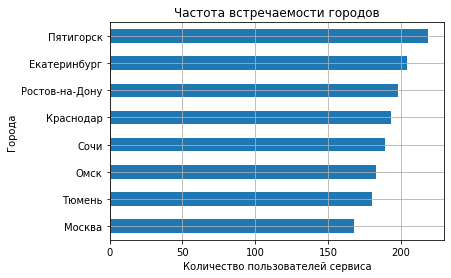

In [16]:
data_users_cities['user_id'].sort_values(ascending=True).plot(kind='barh', grid=True)
plt.title('Частота встречаемости городов')
plt.ylabel('Города')
plt.xlabel('Количество пользователей сервиса')
plt.show()

Видим, что большинство пользователей из Пятигорска (14% всех пользователей), меньше всего - в Москве (11%). Предположительно связано с основным городом базирования предприятия и количеством точек/самокатов в аренду. 

<a id='Соотношение-подписок'></a>
Найдем соотношение пользователей с подпиской и без:

In [17]:
data_users_subs = data_users.pivot_table(index='subscription_type', values='user_id', aggfunc='count')\
.sort_values(by='user_id', ascending=False)
data_users_subs['total_users'] = data_users_subs['user_id'].sum()
data_users_subs['part_subs'] = data_users_subs['user_id']/data_users_subs['total_users']*100
data_users_subs

,user_id,total_users,part_subs
subscription_type,,,
free,835,1534,54.432855
ultra,699,1534,45.567145


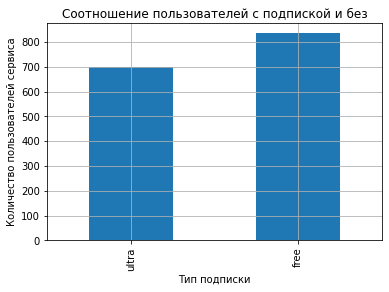

In [18]:
data_users_subs['user_id'].sort_values(ascending=True).plot(kind='bar', grid=True)
plt.title('Соотношение пользователей с подпиской и без')
plt.xlabel('Тип подписки')
plt.ylabel('Количество пользователей сервиса')
plt.show()

Для наглядности представим в виде круговой диаграммы:

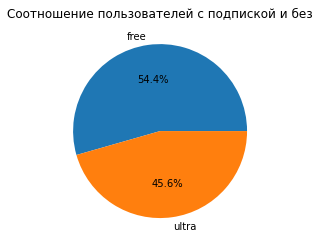

In [19]:
plt.pie(data_users_subs['user_id'], labels=['free', 'ultra'], autopct='%1.1f%%')
plt.title('Соотношение пользователей с подпиской и без')
plt.show()

Количество пользователей сервиса без подписки больше почти на 10% от общего количества. Однако 45% пользователей с подпиской, предварительно, - хороший результат.

<a id='Возраст-пользователей'></a>
Посмотрим на возраст пользователей:

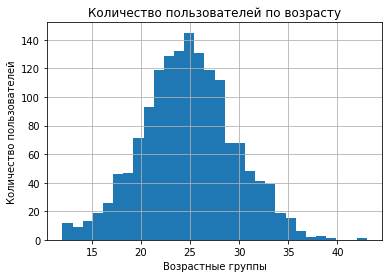

In [20]:
data_users['age'].hist(bins=30)
plt.title('Количество пользователей по возрасту')
plt.ylabel('Количество пользователей')
plt.xlabel('Возрастные группы')
plt.show()

При обзоре датасетов мы уже видели нормальное распределение значений по возрасту со средним 25 лет и небольшим количеством пользователей в возрасте около 42-43 лет.

Взглянем на рассчитаное среднее и медиану для точности:

In [21]:
data_users['age'].describe()

count    1534.000000
mean       24.903520
std         4.572367
min        12.000000
25%        22.000000
50%        25.000000
75%        28.000000
max        43.000000
Name: age, dtype: float64

Медиана и среднее практически равны - данные однородны. 

<a id='Расстояние-поездки'></a>
Аналогично рассмотрим расстояние, преодолеваемое пользователем за 1 поездку:

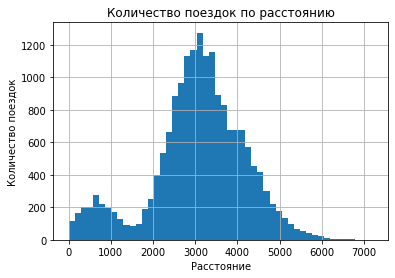

In [22]:
data_rides['distance'].hist(bins=50)
plt.title('Количество поездок по расстоянию')
plt.ylabel('Количество поездок')
plt.xlabel('Расстояние')
plt.show()

У гистограммы есть 2 пика: небольшой в 650м и основной в 3100м, определим среднее и медиану значений:

In [23]:
data_rides['distance'].describe()

count    18068.000000
mean      3070.659976
std       1116.831209
min          0.855683
25%       2543.226360
50%       3133.609994
75%       3776.222735
max       7211.007745
Name: distance, dtype: float64

Среднее расстояние поездки равно 3133м, выглядит правдоподобно, как и, приблизительно, 300 поездок около 650м - не все используют электросамокаты для передвижения на сравнительно далекие расстояния, иногда необходимо быстро добраться до близкой точки интереса.

Также мы видим минимальное расстояние равное 0.85 метра - возможно, это случаи, когда пользователи брали самокат в аренду и сразу же отменяли, таких значений в датасете около 100, что не сильно влияет на качество данных. 

<a id='Продолжительность-поездки'></a>
Уделим внимание и длительности поездок:

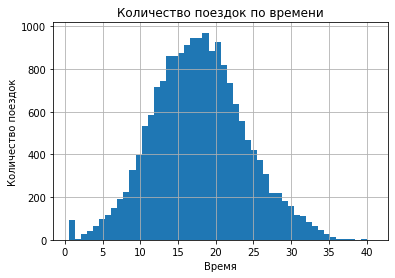

In [24]:
data_rides['duration'].hist(bins=50)
plt.title('Количество поездок по времени')
plt.ylabel('Количество поездок')
plt.xlabel('Время')
plt.show()

Значения нормально распределены вокруг 18 минут, что и является примерным средним временем поездки. Еще заметны значения поездки около 1 минуты - возможно, это те же поездки на расстояние около 1 метра. 

Рассмотрим такие поездки более детально:

In [25]:
data_rides[data_rides['duration']<2].describe()

,user_id,distance,duration,month
count,95.000000,95.000000,95.0,95.000000
mean,1092.210526,5113.176549,0.5,6.484211
std,244.028551,658.254104,0.0,3.709858
min,701.000000,4030.308008,0.5,1.000000
25%,901.000000,4611.510820,0.5,3.000000
50%,1069.000000,5052.769411,0.5,6.000000
75%,1310.500000,5488.459099,0.5,10.000000
max,1524.000000,7211.007745,0.5,12.000000


Видим, что минимальная дистанция для поездок в диапазоне 0-2 минуты составляет 4км. Предположение оказалось неверным: без отдельных расчетов понятно, что скорость самоката в данных случаях превышает максимальную - эти значения примем, как аномальные, которые на данном этапе мы не можем скорректировать или удалить - неизвестно в чем ошибка в данных: во времени или расстоянии, а строки необходимы нам для учета пользователей.

Определим среднее и медиану более точно:

In [26]:
data_rides['duration'].describe()

count    18068.000000
mean        17.805011
std          6.091051
min          0.500000
25%         13.597563
50%         17.678395
75%         21.724800
max         40.823963
Name: duration, dtype: float64

Среднее время составляет 17 минут 48 секунд - вполне стандартная длительность поездки. 

**Вывод:**

Мы более подробно исследовали данные:

* Больше всего пользователей сервиса в Пятигорске (14%), меньше всего - в Москве(11%);
* Бользователей с подпиской - 699(45%), без подписки - 835;
* Возраст пользователей нормально распределен вокруг среднего - 25 лет;
* Расстояние, преодолеваемое пользователями сервиса, собрано, в основном, вокруг 3100м, второй пик в 650м представлен 300 поездками, вокруг которого так же собраны значения, подобные нормальному распределению отностиельно пика. Существуют поездки на расстояние около 1м, связанные, скорее всего, со скорой отменой аренды;
* Время поездки нормально распределено вокруг среднего 17 минут 48 секунд, есть аномальные поездки - около 1 минуты. 

[Вернуться к содержанию](#Содержание)

<a id='Объединение-данных'></a>
## Объединение данных

<a id='Соединение-таблиц'></a>
Объединим данные о пользователях, поездках и подписках в один датафрейм:

In [27]:
#выделим изначальное количество строк для последующей проверки
print('Количество строк в "Пользователи":', len(data_users['user_id']))
print('Количество строк в "Поездки":', len(data_rides['user_id']))
print('Количество строк в "Подписки":', len(data_subs['subscription_type']))

Количество строк в "Пользователи": 1534
Количество строк в "Поездки": 18068
Количество строк в "Подписки": 2


In [28]:
data_total = pd.merge(data_users, data_rides, on='user_id')
#проверяем, как прошло слияние
print('Количество строк в общем датафрейме:', len(data_total['user_id']))
data_total.head(3)

Количество строк в общем датафрейме: 18068


,user_id,name,age,city,subscription_type,distance,duration,date,month
0,1,Кира,22,Тюмень,ultra,4409.919140,25.599769,2021-01-01,1
1,1,Кира,22,Тюмень,ultra,2617.592153,15.816871,2021-01-18,1
2,1,Кира,22,Тюмень,ultra,754.159807,6.232113,2021-04-20,4


In [29]:
data_total = data_total.merge(data_subs, on='subscription_type')
print('Количество строк в общем датафрейме:', len(data_total['user_id']))
data_total.head(3)

Количество строк в общем датафрейме: 18068


,user_id,name,age,city,subscription_type,distance,duration,date,month,minute_price,start_ride_price,subscription_fee
0,1,Кира,22,Тюмень,ultra,4409.919140,25.599769,2021-01-01,1,6,0,199
1,1,Кира,22,Тюмень,ultra,2617.592153,15.816871,2021-01-18,1,6,0,199
2,1,Кира,22,Тюмень,ultra,754.159807,6.232113,2021-04-20,4,6,0,199


Теперь у нас есть общий датафрейм *data_total*, создадим на его основе 2 датафрейма: пользователи с подпиской и без нее:

In [30]:
data_total_ultra = data_total[data_total['subscription_type']=='ultra']
data_total_ultra.sample(10)

,user_id,name,age,city,subscription_type,distance,duration,date,month,minute_price,start_ride_price,subscription_fee
4465,481,Наташа,24,Тюмень,ultra,3586.006072,27.560033,2021-07-15,7,6,0,199
4527,488,Владимир,31,Пятигорск,ultra,2922.605790,14.315079,2021-04-24,4,6,0,199
6088,653,Вадим,28,Пятигорск,ultra,2785.071244,20.355214,2021-01-12,1,6,0,199
3537,380,Валерий,33,Сочи,ultra,3353.354068,20.738509,2021-04-17,4,6,0,199
3524,379,Айдар,27,Ростов-на-Дону,ultra,3667.984433,13.169961,2021-03-11,3,6,0,199
868,93,Вадим,25,Пятигорск,ultra,4868.553325,25.605660,2021-06-24,6,6,0,199
2559,271,Эмилия,22,Пятигорск,ultra,3382.370811,18.683891,2021-02-21,2,6,0,199
2826,302,Наталия,27,Ростов-на-Дону,ultra,1004.882613,13.546645,2021-07-21,7,6,0,199
4083,440,Амалия,20,Тюмень,ultra,2875.313112,22.584377,2021-01-02,1,6,0,199
4244,458,Самир,21,Екатеринбург,ultra,3021.328791,14.474276,2021-03-16,3,6,0,199


In [31]:
data_total_free = data_total[data_total['subscription_type']=='free']
data_total_free.sample(10)

,user_id,name,age,city,subscription_type,distance,duration,date,month,minute_price,start_ride_price,subscription_fee
18065,1534,Альберт,25,Краснодар,free,3826.185507,18.435051,2021-11-18,11,8,50,0
17808,1517,Давид,25,Тюмень,free,180.812768,11.493126,2021-01-10,1,8,50,0
16098,1396,Георгий,24,Краснодар,free,4968.694281,23.647202,2021-05-10,5,8,50,0
7126,743,Арсен,18,Тюмень,free,2767.321806,11.929975,2021-03-12,3,8,50,0
16366,1414,Лариса,25,Краснодар,free,1167.769243,14.336484,2021-08-21,8,8,50,0
9958,955,Амир,18,Сочи,free,380.419209,16.075014,2021-01-01,1,8,50,0
10667,1004,Амина,21,Сочи,free,2958.869600,23.095761,2021-08-23,8,8,50,0
15597,1362,Владимир,24,Екатеринбург,free,886.720795,15.660162,2021-01-14,1,8,50,0
7584,778,Эдуард,22,Ростов-на-Дону,free,4090.365647,25.451828,2021-11-06,11,8,50,0
10979,1026,Савелий,26,Тюмень,free,2344.036818,19.022936,2021-07-12,7,8,50,0


<a id='Сравнение'></a>
Сравним расстояние и время поездок для обеих категорий пользователей:

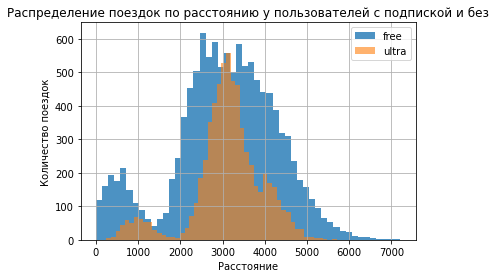

In [32]:
#построим объединенную гистограмму по расстоянию поездок
ax = data_total_free['distance'].hist(bins=50, grid=True, label='free', alpha=0.8)
ax = data_total_ultra['distance'].hist(bins=50, grid=True, label='ultra', alpha=0.6)
ax.legend(loc='upper right')
plt.title('Распределение поездок по расстоянию у пользователей с подпиской и без')
plt.xlabel('Расстояние')
plt.ylabel('Количество поездок')
plt.show()

Согласно гистограмме расстояния поездок обе категории пользователей имеют примерно равное распределение значений. Отметим: меньшее количество поездок у пользователей с подпиской (таких пользователей меньше на 10%), 2 пика распределения поездок пользователей с подпиской (аналогично free) имеют положительное среднее отклонение по расстоянию в, примерно, 300 метров. Также расстояние близ нуля наблюдается только у пользователей без подписки.

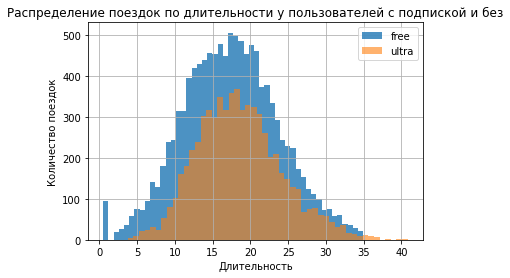

In [33]:
#построим объединенную гистограмму по времени
ax = data_total_free['duration'].hist(bins=50, grid=True, label='free', alpha=0.8)
ax = data_total_ultra['duration'].hist(bins=50, grid=True, label='ultra', alpha=0.6)
ax.legend(loc='upper right')
plt.title('Распределение поездок по длительности у пользователей с подпиской и без')
plt.xlabel('Длительность')
plt.ylabel('Количество поездок')
plt.show()

По гистограмме сравнительного распределения времени на поездки видим, что 2 категории равны, за исключением количества и длительности возле нуля у пользователей без подписки, что согласуется, соответственно, и с расстоянием поездок. 

**Вывод:**

Мы провели объединение данных 3 датасетов:

* Соединили "Пользователей", "Поездки" и "Подписки" без потери строк;
* Сравнили расстояние и длительность поездок пользователей с подписками и без: распределения примерно одинаковые, у пользователей без подписок наблюдаются поездки длительностью около 1 минуты и с расстоянием около 1 метра, что, возможно, связано с ошибочной арендой/попыткой протестировать работу сервиса.


[Вернуться к содержанию](#Содержание)

<a id='Подсчет-выручки'></a>
## Подсчёт выручки

Посчитаем помесячную выручку сервиса с каждого пользователя.

Для этого создадим новый агрегированный датафрейм на основе общего:

In [34]:
#сначала округлим значения продолжительности для корректности рассчетов
data_total['duration'] = np.ceil(data_total['duration'])
#создаем сводную таблицу - новый дф
data_total_agg = data_total.pivot_table(index=['user_id', 'month'], values =['distance', 'duration'], aggfunc=['count', 'sum'])
#избавляемся от мультииндексации 
data_total_agg.columns = ['count_rides', 'count_duration', 'sum_distance', 'sum_duration']
#удаляем лишний столбец
data_total_agg = data_total_agg.drop(columns='count_duration')
data_total_agg.head(10)

count_rides  sum_distance  sum_duration
user_id month                                         
1       1                2   7027.511294          42.0
        4                1    754.159807           7.0
        8                2   6723.470560          46.0
        10               2   5809.911100          32.0
        11               3   7003.499363          56.0
        12               2   6751.629942          28.0
2       3                3  10187.723006          63.0
        4                2   6164.381824          40.0
        6                1   3255.338202          14.0
        7                2   6780.722964          48.0

Описание таблицы:

 * *user_id* — уникальный идентификатор пользователя
 * *month* — месяц, за который идет посчет значений
 * *count_rides* — количество поездок
 * *sum_distance* — общее расстояние поездок в метрах
 * *sum_duration* — общая продолжительность поездок в минутах

Добавим к новой таблице столбец с помесячной выручкой от каждого пользователя, для этого также добавим столбцы с данными о подписке и ценовых условиях:

In [35]:
 #соединим с таблицами по пользователям и тарифам
data_total_agg.reset_index(inplace=True)
data_total_agg = data_total_agg.merge(data_users, on='user_id')
data_total_agg = data_total_agg.merge(data_subs, on='subscription_type')
data_total_agg.head(10)

,user_id,month,count_rides,sum_distance,sum_duration,name,age,city,subscription_type,minute_price,start_ride_price,subscription_fee
0,1,1,2,7027.511294,42.0,Кира,22,Тюмень,ultra,6,0,199
1,1,4,1,754.159807,7.0,Кира,22,Тюмень,ultra,6,0,199
2,1,8,2,6723.470560,46.0,Кира,22,Тюмень,ultra,6,0,199
3,1,10,2,5809.911100,32.0,Кира,22,Тюмень,ultra,6,0,199
4,1,11,3,7003.499363,56.0,Кира,22,Тюмень,ultra,6,0,199
5,1,12,2,6751.629942,28.0,Кира,22,Тюмень,ultra,6,0,199
6,2,3,3,10187.723006,63.0,Станислав,31,Омск,ultra,6,0,199
7,2,4,2,6164.381824,40.0,Станислав,31,Омск,ultra,6,0,199
8,2,6,1,3255.338202,14.0,Станислав,31,Омск,ultra,6,0,199
9,2,7,2,6780.722964,48.0,Станислав,31,Омск,ultra,6,0,199


In [36]:
#добавим столбец с помесячной выручкой от клиента
data_total_agg['month_rev'] = data_total_agg['start_ride_price'] * data_total_agg['count_rides'] +\
                              data_total_agg['minute_price'] * data_total_agg['sum_duration'] +\
                              data_total_agg['subscription_fee']
data_total_agg.head(10)

,user_id,month,count_rides,sum_distance,sum_duration,name,age,city,subscription_type,minute_price,start_ride_price,subscription_fee,month_rev
0,1,1,2,7027.511294,42.0,Кира,22,Тюмень,ultra,6,0,199,451.0
1,1,4,1,754.159807,7.0,Кира,22,Тюмень,ultra,6,0,199,241.0
2,1,8,2,6723.470560,46.0,Кира,22,Тюмень,ultra,6,0,199,475.0
3,1,10,2,5809.911100,32.0,Кира,22,Тюмень,ultra,6,0,199,391.0
4,1,11,3,7003.499363,56.0,Кира,22,Тюмень,ultra,6,0,199,535.0
5,1,12,2,6751.629942,28.0,Кира,22,Тюмень,ultra,6,0,199,367.0
6,2,3,3,10187.723006,63.0,Станислав,31,Омск,ultra,6,0,199,577.0
7,2,4,2,6164.381824,40.0,Станислав,31,Омск,ultra,6,0,199,439.0
8,2,6,1,3255.338202,14.0,Станислав,31,Омск,ultra,6,0,199,283.0
9,2,7,2,6780.722964,48.0,Станислав,31,Омск,ultra,6,0,199,487.0


Теперь у нас есть помесячные значения выручки по каждому клиенту, которые пригодятся нам при проверке гипотез.

**Вывод:**

* Был создан новый датафрейм с агрегированными значениями: сумма продолжительности и расстояния поездок;
* Рассчитана помесячная выручка от каждого клиента - соответствующий столбец добавлен в новый датафрейм.

[Вернуться к содержанию](#Содержание)

<a id='Проверка-гипотез'></a>
## Проверка гипотез

Продакт-менеджеры сервиса хотят увеличить количество пользователей с подпиской. Для этого они хотят провести различные акции, но сначала нужно выяснить несколько важных моментов. 

При исследовательском анализе данных мы уже могли сформировать ответы на вопросы исследования, но необходимо более комплексное и точное решение.

Поэтому будем проверять гипотезы. 

<a id='Время-на-поездку'></a>
Важно понять, тратят ли пользователи с подпиской больше времени на поездки? Если да, то пользователи с подпиской могут быть «выгоднее» для компании.

Сформируем гипотезы:

H0: Пользователи с подпиской тратят столько же времени на поездки, сколько пользователи без подписки.

H1: Пользователи с подпиской тратят больше времени на поездки, чем пользователи без подписки.

In [37]:
#для проверки гипотезы будем использовать односторонний двухвыборочный Т-тест для независимых выборок

alpha = 0.05

results = st.ttest_ind(data_total_ultra['duration'], data_total_free['duration'], alternative='greater')

print('p-значение:', results.pvalue)

if results.pvalue < alpha:
    print('Отвергаем нулевую гипотезу: время поездки значимо больше у пользователей с подпиской')
else:
    print('Не получилось отвергнуть нулевую гипотезу: время поездок достигает запланированных показателей')

p-значение: 1.2804098316645618e-34
Отвергаем нулевую гипотезу: время поездки значимо больше у пользователей с подпиской


При исследовании данных, мы строили сравнительную гистограмму длительности поездок, проверим средние значения двух распределений:

In [38]:
print('Среднее время поездки у пользователей с подпиской:', data_total_ultra['duration'].mean())
print('Среднее время поездки у пользователей без подписки:', data_total_free['duration'].mean())

Среднее время поездки у пользователей с подпиской: 18.54198516280583
Среднее время поездки у пользователей без подписки: 17.39090929866399


Таким образом, пользователи с подпиской тратят больше времени на поездку - H1 правдоподобна.
Поэтому, если учитывать этот фактор в отдельности от других, то пользователи с подпиской приоритетнее для компании. 

<a id='Среднее-расстояние-поездки'></a>
Расстояние одной поездки в 3130 метров — оптимальное с точки зрения износа самоката. Можно ли сказать, что среднее расстояние, которое проезжают пользователи с подпиской за одну поездку, не превышает 3130 метров? 

Сформируем гипотезы:

H0: Пользователи с подпиской в среднем проезжают за 1 поездку 3130 м.

H1: Пользователи с подпиской в среднем за поездку проезжают более 3130 м.

In [39]:
#для проверки гипотезы будем использовать односторонний одновыборочный Т-тест
value = 3130

alpha = 0.05

results = st.ttest_1samp(data_total_ultra['distance'], value, alternative='greater')

print('p-значение:', results.pvalue)

if results.pvalue < alpha:
    print('Отвергаем нулевую гипотезу: дистанция поездки значимо больше у пользователей с подпиской')
else:
    print('Не получилось отвергнуть нулевую гипотезу: дистанция достигает запланированных показателей')

p-значение: 0.9195368847849785
Не получилось отвергнуть нулевую гипотезу: дистанция достигает запланированных показателей


Судя по Т-тесту, среднее значение расстояния поездок у пользователей с подпиской распределено вокруг нашего показателя в 3130 м (p-value 9% - вероятность случайно получить 3130 при условии, что средняя дистанция действительно равна 3130м у пользователей с подпиской), примерно это мы уже видели на гистограмме про исследовании данных. 

Таким образом наша нулевая гипотеза не отвергается. Теперь вычислим конкретное значение: 

In [40]:
print('Средняя дистанция поездки у пользователей с подпиской:', data_total_ultra['distance'].mean())

Средняя дистанция поездки у пользователей с подпиской: 3115.4453880370247


Значение близко к 3130 по левую сторону - поскольку нулевая гипотеза отсекает правую часть, она выглядит более правдоподобной.

Средняя дистанция поездок пользователей с подписками равна или меньше оптимальной по износу самокатов. 

<a id='Сравнение-выручки'></a>
Будет ли помесячная выручка от пользователей с подпиской по месяцам выше, чем выручка от пользователей без подписки?

H0: Помесячная выручка от пользователей с подпиской по месяцам равна выручке от пользователей без подписки.

H1: Помесячная выручка от пользователей с подпиской по месяцам выше, чем выручка от пользователей без подписки.

In [41]:
#для проверки гипотезы будем использовать односторонний двухвыборочный Т-тест для независимых выборок

alpha = 0.05

results = st.ttest_ind(data_total_agg[data_total_agg['subscription_type']=='ultra']['month_rev'],\
          data_total_agg[data_total_agg['subscription_type']=='free']['month_rev'], alternative='greater')

print('p-значение:', results.pvalue)

if results.pvalue < alpha:
    print('Отвергаем нулевую гипотезу: выручка по месяцам от пользователей с подпиской значимо больше, \
чем от пользователей без нее')
else:
    print('Не получилось отвергнуть нулевую гипотезу: помесячная выручка достигает запланированных показателей')

p-значение: 1.8850394384715216e-31
Отвергаем нулевую гипотезу: выручка по месяцам от пользователей с подпиской значимо больше, чем от пользователей без нее


Таким образом, помесячная выручка от клиентов с подпиской, вероятно, выше, чем от клиентов без нее.

Выясним на конкретных значениях:

In [42]:
print('Средняя помесячная выручка от пользователей с подпиской:', 
      data_total_agg[data_total_agg['subscription_type']=='ultra']['month_rev'].mean())
print('Средняя помесячная выручка от пользователей без подписки:', 
      data_total_agg[data_total_agg['subscription_type']=='free']['month_rev'].mean())

Средняя помесячная выручка от пользователей с подпиской: 362.7921906022502
Средняя помесячная выручка от пользователей без подписки: 328.6413651073845


Видим, что выручка от пользователей с подпиской действительно выше. 

**Вывод:**

Проверили и подтвердили относительно высокую вероятность следующих гипотез:
* Пользователи с подпиской тратят больше времени на поездку - более вероятно, чем H0;
* Среднее расстояние, которое проезжают пользователи с подпиской за одну поездку, не превышает 3130 метров - подтверждена;
* Помесячная выручка от пользователей с подпиской по месяцам выше, чем выручка от пользователей без подписки - подтверждена. 

[Вернуться к содержанию](#Содержание)

**Вопрос:** Представьте такую ситуацию: техническая команда сервиса обновила сервера, с которыми взаимодействует мобильное приложение. Она надеется, что из-за этого количество обращений в техподдержку значимо снизилось. Некоторый файл содержит для каждого пользователя данные о количестве обращений до обновления и после него. Какой тест вам понадобился бы для проверки этой гипотезы?

**Ответ:** понадобился бы односторонний Т-тест для зависимых выборок: scipy.stats.ttest_rel. 

<a id='Распределения'></a>
## Распределения

Отделу маркетинга GoFast поставили задачу: нужно провести акцию с раздачей промокодов на один бесплатный месяц подписки, в рамках которой как минимум 100 существующих клиентов должны продлить эту подписку. То есть по завершении периода действия подписки пользователь может либо отказаться от неё, либо продлить, совершив соответствующий платёж. 

Эта акция уже проводилась ранее и по итогу выяснилось, что после бесплатного пробного периода подписку продлевают 10 % пользователей. Выясните, какое минимальное количество промокодов нужно разослать, чтобы вероятность не выполнить план была примерно 5 %. Подберите параметры распределения, описывающего эту ситуацию, постройте график распределения и сформулируйте ответ на вопрос о количестве промокодов:

Поскольку продление подписки после пробного периода - это эксперимент Бернулли (2 исхода: удача (продление) или неудача (без продления)), а таких экспериментов множество, то правильным распределением будет биномиальное, построим его: 

/opt/conda/lib/python3.9/site-packages/scipy/stats/_discrete_distns.py:78: RuntimeWarning: divide by zero encountered in _binom_pdf
  return _boost._binom_pdf(x, n, p)


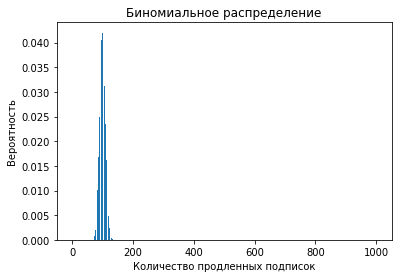

In [43]:
n = 1000 # количество попыток примерное на основе 100 минимальных случаев успеха и 10% вероятности 
p = 0.1 # вероятность успеха на основе предыдущей акции

distr = []

for k in range(0, n + 1):
    current_value = binom.pmf(k, n, p)
    distr.append(current_value)
    
plt.bar(range(0, n + 1), distr)
plt.title('Биномиальное распределение')
plt.xlabel('Количество продленных подписок')
plt.ylabel('Вероятность')
plt.show()

In [44]:
#найдем минимальное количество промокодов (n), чтобы эксперимент бернулли оказался успехом минимум 100 раз с 95% вероятностью,
#будем использовать cdf с такой логикой: создадим цикл, в каждой итерации будет рассчитываться куммулятивная вероятность
#для числа в цикле, при котором получение 100 подписок будет возможно с 95% вероятностью
p = 0.1 #вероятность успеха на основе предыдущей акции
k = 100 #минимальное количество успехов
a = 0.05 #порог вероятности не достичь k успехов
min_n = 1000  #с этого числа начнется цикл, берем 1000, т.к. на основе 100 успехов и 10% вероятности получается именно оно 

while True:
    prob = 1 - binom.cdf(k, min_n, p)
    
    if prob >= 1 - a: #если вероятность получить 100 успехов при найденном min_n больше или равна 95%, то останавливаем цикл
        break
    min_n = min_n + 1 #если при текущем числе необходимой вероятности не найдено, то переходим к следующему числу по порядку
min_n

1172

Необходимо 1172 промокода, чтобы достичь минимума в 100 подписок с 95% вероятностью при текущей конверсии. 

Отдел маркетинга рассылает клиентам push-уведомления в мобильном приложении. Клиенты могут открыть его или не открывать. Известно, что уведомления открывают около 40 % получивших клиентов. Отдел планирует разослать 1 млн уведомлений. С помощью аппроксимации постройте примерный график распределения и оцените вероятность того, что уведомление откроют не более 399,5 тыс. пользователей.

In [45]:
#воспользуемся нормальной аппроксимацией биномиального распределения
n = 1000000
p = 0.4

mu = n * p #мат ожидание 
sigma = (n * p * (1 - p))**0.5 #ст отклонение

distr = st.norm(mu, sigma) #задаем нормальное распределение

result = distr.cdf(399500) #вероятность получить указанное значение или меньше с помощью куммулятивной функции
result

0.15371708296369768

Вероятность того, что уведомление откроют не более 399,5 тыс. пользователей равна 15%.

<a id="Общий-вывод"></a>
## Общий вывод

На основе предоставленных данных было исследовано:

* Большинство пользователей из Пятигорска (14% всех пользователей), меньше всего - в Москве (11%). Предположительно связано с основным городом базирования предприятия и количеством точек/самокатов в аренду;
* Количество пользователей сервиса без подписки больше почти на 10% от общего количества (С подпиской: 699, Без подписки: 835);
* Средний возраст пользователей, вокруг которого распределены другие возрастные группы, равен 25;
* Среднее расстояние поездки равно 3133м, существует 300 поездок около 650м - не все используют электросамокаты для передвижения на сравнительно далекие расстояния, минимальное расстояние у них равно 0.85 метра - возможно, это случаи, когда пользователи брали самокат в аренду и сразу же отменяли;
* Время поездки распределено вокруг среднего 17 минут 48 секунд.

Также проверены 3 гипотезы, у которых высокая вероятность:

* Пользователи с подпиской тратят больше времени на поездку. Поэтому, если учитывать этот фактор в отдельности от других, то пользователи с подпиской приоритетнее для компании;
* Средняя дистанция поездок пользователей с подписками близка к оптимальной по износу самокатов (3130м) и составляет 3115,5м;
* Помесячная выручка от пользователей с подпиской выше, чем от пользователей без подписки, на 4% от общей помесячной выручки (с подпиской: 362, без подписки: 328).

По всем рассмотренным гипотезам клиенты с подпиской выгоднее для компании. 

[Вернуться к содержанию](#Содержание)